<a href="https://colab.research.google.com/github/vadhri/distibuted-optimization/blob/main/AugmentnedLagrangian.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

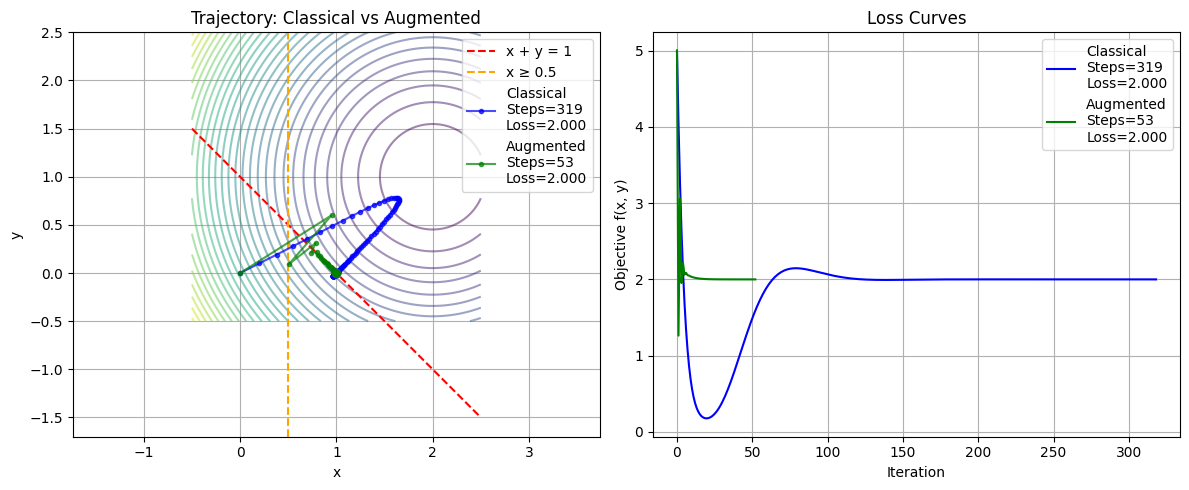

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Objective
def f(x):
    return (x[0] - 2)**2 + (x[1] - 1)**2

# Equality and inequality constraints
def g(x): return x[0] + x[1] - 1
def h(x): return 0.5 - x[0]

# Classical Lagrangian
def L(x, lam): return f(x) + lam * g(x)

def solve_classical_lagrangian_gd(x0, lam0=0.0, lr=0.05, max_iter=500, tol=1e-7):
    x, lam = x0.copy(), lam0
    traj, losses, std_window = [x.copy()], [f(x)], []
    for _ in range(max_iter):
        grad_x = np.zeros_like(x)
        eps = 1e-6
        for j in range(len(x)):
            x_eps = x.copy()
            x_eps[j] += eps
            grad_x[j] = (L(x_eps, lam) - L(x, lam)) / eps
        grad_lam = g(x)

        x -= lr * grad_x
        lam += lr * grad_lam

        loss = f(x)
        traj.append(x.copy())
        losses.append(loss)
        std_window.append(loss)
        if len(std_window) > 10:
            std_window.pop(0)
            if np.std(std_window) < tol:
                break
    return x, lam, np.array(traj), losses

# Augmented Lagrangian
def augmented_lagrangian(x, lam, mu, rho):
    penalty = lam * g(x) + 0.5 * rho * g(x)**2
    if h(x) > 0:
        penalty += mu * h(x) + 0.5 * rho * h(x)**2
    return f(x) + penalty

def optimize_augmented_lagrangian(x0, lam=0.0, mu=0.0, rho=10.0, max_iter=100, eta=0.05, tol=1e-5):
    x = x0.copy()
    trajectory, losses, std_window = [x.copy()], [f(x)], []
    for _ in range(max_iter):
        grad = np.zeros_like(x)
        eps = 1e-6
        for i in range(len(x)):
            x_eps = x.copy()
            x_eps[i] += eps
            grad[i] = (augmented_lagrangian(x_eps, lam, mu, rho) - augmented_lagrangian(x, lam, mu, rho)) / eps
        x -= eta * grad

        lam += rho * g(x)
        mu = max(0, mu + rho * h(x))

        loss = f(x)
        trajectory.append(x.copy())
        losses.append(loss)

        std_window.append(loss)
        if len(std_window) > 10:
            std_window.pop(0)
            if np.std(std_window) < tol:
                break
    return x, lam, np.array(trajectory), losses

# --- Run both methods ---
x0 = np.array([0.0, 0.0])
x_classical, lam_classical, traj_classical, loss_classical = solve_classical_lagrangian_gd(x0)
x_aug, lam_aug, traj_aug, loss_aug = optimize_augmented_lagrangian(x0)

# --- Plot ---
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Plot 1: Trajectory
X, Y = np.meshgrid(np.linspace(-0.5, 2.5, 200), np.linspace(-0.5, 2.5, 200))
Z = (X - 2)**2 + (Y - 1)**2
ax[0].contour(X, Y, Z, levels=30, cmap='viridis', alpha=0.5)

x_line = np.linspace(-0.5, 2.5, 200)
ax[0].plot(x_line, 1 - x_line, 'r--', label='x + y = 1')
ax[0].axvline(0.5, color='orange', linestyle='--', label='x ≥ 0.5')

ax[0].plot(traj_classical[:, 0], traj_classical[:, 1], 'b.-', alpha=0.7,
           label=f'Classical\nSteps={len(loss_classical)}\nLoss={loss_classical[-1]:.3f}')
ax[0].plot(traj_aug[:, 0], traj_aug[:, 1], 'g.-', alpha=0.7,
           label=f'Augmented\nSteps={len(loss_aug)}\nLoss={loss_aug[-1]:.3f}')

ax[0].plot(*traj_classical[-1], 'bo')
ax[0].plot(*traj_aug[-1], 'go')
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')
ax[0].set_title('Trajectory: Classical vs Augmented')
ax[0].legend()
ax[0].grid(True)
ax[0].axis('equal')

# Plot 2: Loss curves
ax[1].plot(loss_classical, 'b-', label=f'Classical\nSteps={len(loss_classical)}\nLoss={loss_classical[-1]:.3f}')
ax[1].plot(loss_aug, 'g-', label=f'Augmented\nSteps={len(loss_aug)}\nLoss={loss_aug[-1]:.3f}')
ax[1].set_xlabel("Iteration")
ax[1].set_ylabel("Objective f(x, y)")
ax[1].set_title("Loss Curves")
ax[1].legend()
ax[1].grid(True)

plt.tight_layout()
plt.show()
